In [2]:
%load_ext autoreload
%autoreload 1

In [2]:
import wandb
KEYS = {"WANDB_KEY": "9d3188c4797b9920e53604b881bf05b4607193de"}

wandb.login(key=KEYS["WANDB_KEY"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mel2-da (mel2-da-ai). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/remote_user/.netrc


True

In [3]:
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import wandb
from dataloader import create_dataloader
from lightning.pytorch.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from pytorch_lightning.loggers import WandbLogger
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary

In [4]:
%aimport classifier_trainer
%aimport models

/home/remote_user/mambaforge/envs/ml_lab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
images_col = "segmented_file_path"
optimizer_adam = True

train = create_dataloader(
    Path("../data/INbreast Release 1.0/train_processed_png_labels.csv"),
    is_train=True,
    weighted_train_sampler=True,
    batch_size=20,
    num_workers=0,
    images_path_col=images_col,
    # unprocessed_file_path,ma_file_path,normalized_file_path,segmented_file_path
)
test = create_dataloader(
    Path("../data/INbreast Release 1.0/test_processed_png_labels.csv"),
    is_train=False,
    weighted_train_sampler=False,
    batch_size=20,
    num_workers=0,
    images_path_col=images_col,
)

batch_shape = next(iter(train))[0].shape
batch_shape

Use weighted train sampler
Dataset disribution: {0: 54, 1: 195, 2: 79}
Min class ocurrences: 54
Class weights: {0: 0.018518518518518517, 1: 0.005128205128205128, 2: 0.012658227848101266}


torch.Size([20, 3, 224, 224])

In [11]:
data = next(iter(train))[0]
data

tensor([[[[ -2.1179,  -2.1179,  -2.1179,  ...,  -2.1179,  -2.1179,  -2.1179],
          [ -2.1179,  -2.1179,  -2.1179,  ...,  -2.1179,  -2.1179,  -2.1179],
          [ -2.1179,  -2.1179,  -2.1179,  ...,  -2.1179,  -2.1179,  -2.1179],
          ...,
          [ -2.1179,  -2.1179,  -2.1179,  ...,  -2.1179,  -2.1179,  -2.1179],
          [ -2.1179,  -2.1179,  -2.1179,  ...,  -2.1179,  -2.1179,  -2.1179],
          [ -2.1179,  -2.1179,  -2.1179,  ...,  -2.1179,  -2.1179,  -2.1179]],

         [[ -2.0357,  -2.0357,  -2.0357,  ...,  -2.0357,  -2.0357,  -2.0357],
          [ -2.0357,  -2.0357,  -2.0357,  ...,  -2.0357,  -2.0357,  -2.0357],
          [ -2.0357,  -2.0357,  -2.0357,  ...,  -2.0357,  -2.0357,  -2.0357],
          ...,
          [ -2.0357,  -2.0357,  -2.0357,  ...,  -2.0357,  -2.0357,  -2.0357],
          [ -2.0357,  -2.0357,  -2.0357,  ...,  -2.0357,  -2.0357,  -2.0357],
          [ -2.0357,  -2.0357,  -2.0357,  ...,  -2.0357,  -2.0357,  -2.0357]],

         [[ -1.8044,  -1.8044,

In [13]:
data[0].shape

torch.Size([3, 224, 224])

In [20]:
data[0][0].min()

tensor(-2.1179)

In [21]:
data[0][0].max()

tensor(785.0293)

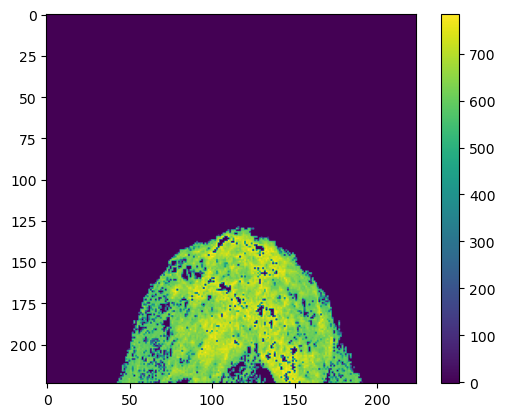

In [19]:
t = plt.imshow(data[0][0])
plt.colorbar(t)
plt.show()

In [6]:
model = models.create_squeezenet_model(False)
summary(
        model,
        input_size=batch_shape,
        col_names=("output_size", "num_params", "trainable"),
        row_settings=["var_names"],
    )

/home/remote_user/mambaforge/envs/ml_lab/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/remote_user/mambaforge/envs/ml_lab/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                       Output Shape              Param #                   Trainable
SqueezeNet (SqueezeNet)                       [20, 3]                   --                        Partial
├─Sequential (features)                       [20, 512, 13, 13]         --                        Partial
│    └─Conv2d (0)                             [20, 96, 109, 109]        (14,208)                  False
│    └─ReLU (1)                               [20, 96, 109, 109]        --                        --
│    └─MaxPool2d (2)                          [20, 96, 54, 54]          --                        --
│    └─Fire (3)                               [20, 128, 54, 54]         --                        False
│    │    └─Conv2d (squeeze)                  [20, 16, 54, 54]          (1,552)                   False
│    │    └─ReLU (squeeze_activation)         [20, 16, 54, 54]          --                        --
│    │    └─Conv2d (expand1x1)                [20, 64, 54, 54]   

In [7]:
if optimizer_adam:
    adam_params = {
        "lr": 0.01,
        "betas": (0.9, 0.999),
        "weight_decay": 0.0,
        "amsgrad": False,
        "eps": 1e-08,
        # batch_shape 20
        # epochs 20
    }

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=0.001,
        weight_decay=0.0005,
        betas=(0.5, 0.999),
    )
    scheduler = None
else:
    sgd_params = {
        "lr": 0.0001,
        "momentum": 0.9,
        "weight_decay": 0.0001,
        # batch_shape 20
        # epochs 20
        # lr drop factor 0.5
        # lr drop period 5
    }
    optimizer = torch.optim.SGD(model.parameters(), **sgd_params)
    scheduler = StepLR(optimizer, 5, 0.5)

In [8]:
wandb_logger = WandbLogger(project='ml_lab', log_model="all")
clf_trainer = classifier_trainer.ClassifierTrainer(
    net=model,
    optimizer=optimizer,
    scheduler=scheduler,
    num_classes=3,
)

lr_monitor = LearningRateMonitor(logging_interval="step")
early_stopping = EarlyStopping(monitor="roc_auc_avg_val", patience=15, verbose=True, mode="max")
checkpoints = ModelCheckpoint(monitor="roc_auc_avg_val", save_last=True, mode="max")

trainer = L.Trainer(
    max_epochs=20,
    log_every_n_steps=3,
    logger=wandb_logger,
    callbacks=[lr_monitor, early_stopping, checkpoints],
)
trainer.fit(model=clf_trainer, train_dataloaders=train, val_dataloaders=test)
print(wandb.run.summary)

wandb.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name              | Type                      | Params
----------------------------------------------------------------
0 | net               | SqueezeNet                | 736 K 
1 | criterion         | CrossEntropyLoss          | 0     
2 | roc_auc_avg_train | MulticlassAUROC           | 0     
3 | roc_auc_avg_val   | MulticlassAUROC           | 0     
4 | roc_auc_train     | ClasswiseWrapper          | 0     
5 | roc_auc_val       | ClasswiseWrapper          | 0     
6 | cm_train          | MulticlassConfusionMatrix | 0     
7 | cm_val            | MulticlassConfusionMatrix | 0     
----------------------------------------------------------------
198 K     Trainable params
538 K     Non-trainable params
736 K     Total params
2.948     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/remote_user/mambaforge/envs/ml_lab/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/remote_user/mambaforge/envs/ml_lab/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 9/9 [00:38<00:00,  0.24it/s, v_num=hv3b]

Metric roc_auc_avg_val improved. New best score: 0.495


Epoch 15: 100%|██████████| 9/9 [00:38<00:00,  0.24it/s, v_num=hv3b]

Metric roc_auc_avg_val improved by 0.003 >= min_delta = 0.0. New best score: 0.497


Epoch 16: 100%|██████████| 9/9 [00:38<00:00,  0.23it/s, v_num=hv3b]

Metric roc_auc_avg_val improved by 0.003 >= min_delta = 0.0. New best score: 0.500


Epoch 19: 100%|██████████| 9/9 [00:37<00:00,  0.24it/s, v_num=hv3b]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 9/9 [00:37<00:00,  0.24it/s, v_num=hv3b]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


acc_BENIGN_train,█▆▂▆▃▇▄▄▄▅▂▅▂▄▂▃▁▁▂▂
acc_BENIGN_val,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc_MALIGNANT_train,▁▃█▄▆▃▄█▆▆▇▃▃▃▁▃▅▂▄▅
acc_MALIGNANT_val,▄▄▅▇▆▇▇██▁▁▁▁▁▁▁▁▁▁▁
acc_NORMAL_train,▅▃▁▂▁▄▇▄▃▁▃▇█▅▇▅▆▅█▃
acc_NORMAL_val,▅▅▃▂▂▂▁▁▁███████████
acc_avg_train,▆▄▅▇▄▆█▆▆▅▇█▅▅▄▃▇▁█▂
acc_avg_val,▇▆▅▆▅▅▆█▆▁▁▁▁▁▁▁▁▁▁▁
auc_BENIGN_train,█▄▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄
auc_BENIGN_val,▁▄▆██▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇
auc_MALIGNANT_train,█▅▄▃▂▁▁▂▂▂▂▂▂▂▂▂▂▁▁▁


In [9]:
model_lstm = models.create_squeezenet_model(True)
summary(
    model_lstm,
    input_size=batch_shape,
    col_names=("output_size", "num_params", "trainable"),
    row_settings=["var_names"],
)

if optimizer_adam:
    adam_params = {
        "lr": 0.01,
        "betas": (0.9, 0.999),
        "weight_decay": 0.0,
        "amsgrad": False,
        "eps": 1e-08,
        # batch_shape 20
        # epochs 20
    }

    optimizer = torch.optim.Adam(
        model_lstm.parameters(),
        lr=0.001,
        weight_decay=0.0005,
        betas=(0.5, 0.999),
    )
    scheduler = None
else:
    sgd_params = {
        "lr": 0.0001,
        "momentum": 0.9,
        "weight_decay": 0.0001,
        # batch_shape 20
        # epochs 20
        # lr drop factor 0.5
        # lr drop period 5
    }
    optimizer = torch.optim.SGD(model_lstm.parameters(), **sgd_params)
    scheduler = StepLR(optimizer, 5, 0.5)



/home/remote_user/mambaforge/envs/ml_lab/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/remote_user/mambaforge/envs/ml_lab/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
wandb_logger = WandbLogger(project='ml_lab', log_model="all")
clf_trainer = classifier_trainer.ClassifierTrainer(
    net=model_lstm,
    optimizer=optimizer,
    scheduler=scheduler,
    num_classes=3,
)

lr_monitor = LearningRateMonitor(logging_interval="step")
early_stopping = EarlyStopping(monitor="roc_auc_avg_val", patience=15, verbose=True, mode="max")
checkpoints = ModelCheckpoint(monitor="roc_auc_avg_val", save_last=True, mode="max")

trainer = L.Trainer(
    max_epochs=20,
    log_every_n_steps=3,
    logger=wandb_logger,
    callbacks=[lr_monitor, early_stopping, checkpoints],
)
trainer.fit(model=clf_trainer, train_dataloaders=train, val_dataloaders=test)
wandb.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name              | Type                      | Params
----------------------------------------------------------------
0 | net               | CnnLstmModel              | 1.0 M 
1 | criterion         | CrossEntropyLoss          | 0     
2 | roc_auc_avg_train | MulticlassAUROC           | 0     
3 | roc_auc_avg_val   | MulticlassAUROC           | 0     
4 | roc_auc_train     | ClasswiseWrapper          | 0     
5 | roc_auc_val       | ClasswiseWrapper          | 0     
6 | cm_train          | MulticlassConfusionMatrix | 0     
7 | cm_val            | MulticlassConfusionMatrix | 0     
----------------------------------------------------------------
484 K     Trainable params
538 K     Non-trainable params
1.0 M     Total params
4.090     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/remote_user/mambaforge/envs/ml_lab/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/remote_user/mambaforge/envs/ml_lab/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 9/9 [00:40<00:00,  0.22it/s, v_num=4hlw]

Metric roc_auc_avg_val improved. New best score: 0.486


Epoch 1: 100%|██████████| 9/9 [00:41<00:00,  0.22it/s, v_num=4hlw]

Metric roc_auc_avg_val improved by 0.037 >= min_delta = 0.0. New best score: 0.522


Epoch 3: 100%|██████████| 9/9 [00:37<00:00,  0.24it/s, v_num=4hlw]

Metric roc_auc_avg_val improved by 0.050 >= min_delta = 0.0. New best score: 0.572


Epoch 18: 100%|██████████| 9/9 [00:35<00:00,  0.25it/s, v_num=4hlw]

Metric roc_auc_avg_val improved by 0.003 >= min_delta = 0.0. New best score: 0.575


Epoch 19: 100%|██████████| 9/9 [00:39<00:00,  0.23it/s, v_num=4hlw]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 9/9 [00:39<00:00,  0.23it/s, v_num=4hlw]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


acc_BENIGN_train,▁▂▁▁▁▂▇▂▅█▅▄▁▁▆▇▇▂▅▅
acc_BENIGN_val,▁▂▁▂▁▄▂▃▄▅▄▁▁▂▇█▂▃▄▅
acc_MALIGNANT_train,▁▂▂▅█▇▃▅▄▃▄▂▃▄▂▁▁▄▄▄
acc_MALIGNANT_val,▁▁▅▇█▅▂▆▅▅▅▂▆▅▂▁▆▃▄▃
acc_NORMAL_train,██▇▅▁▂▃▄▅▃▂▅▇▆▄▃▂▄▅▄
acc_NORMAL_val,██▆▃▁▃▆▃▂▂▃█▄▆▁▃▃▃▄▆
acc_avg_train,▁▃▃▄▅▃▆▂▆▆▂▃▅▄▂▃▁▁█▅
acc_avg_val,▁▂▄▃▂▅▂▄▅▆▅▁▂▄▇█▃▃▅▆
auc_BENIGN_train,▁▂▄▃▃▅▅▅▆▇▇▇█▇██████
auc_BENIGN_val,▂▃▁▄▅▆▇▇▇███████████
auc_MALIGNANT_train,▄▁▁▄▆▅▇▇▇███▇▇▇▇▇▆▇▇


In [5]:
[20, 3, 224, 224]
model_lstm = models.create_vit_model(False)
summary(
    model_lstm,
    input_size=[20, 3, 224, 224],
    col_names=("output_size", "num_params", "trainable"),
    row_settings=["var_names"],
)


model.safetensors: 100%|██████████| 346M/346M [00:25<00:00, 13.5MB/s] 


Layer (type (var_name))                  Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)    [20, 3]                   152,064                   Partial
├─PatchEmbed (patch_embed)               [20, 196, 768]            --                        False
│    └─Conv2d (proj)                     [20, 768, 14, 14]         (590,592)                 False
│    └─Identity (norm)                   [20, 196, 768]            --                        --
├─Dropout (pos_drop)                     [20, 197, 768]            --                        --
├─Identity (patch_drop)                  [20, 197, 768]            --                        --
├─Identity (norm_pre)                    [20, 197, 768]            --                        --
├─Sequential (blocks)                    [20, 197, 768]            --                        Partial
│    └─Block (0)                         [20, 197, 768]            --                        Partial
│    │    └─

In [6]:
model_lstm = models.create_vit_model(True)
summary(
    model_lstm,
    input_size=[20, 3, 224, 224],
    col_names=("output_size", "num_params", "trainable"),
    row_settings=["var_names"],
)

Layer (type (var_name))                       Output Shape              Param #                   Trainable
CnnLstmModel (CnnLstmModel)                   [20, 3]                   --                        Partial
├─VisionTransformer (feature_extractor)       --                        154,371                   Partial
│    └─PatchEmbed (patch_embed)               [20, 196, 768]            --                        False
│    │    └─Conv2d (proj)                     [20, 768, 14, 14]         (590,592)                 False
│    │    └─Identity (norm)                   [20, 196, 768]            --                        --
│    └─Dropout (pos_drop)                     [20, 197, 768]            --                        --
│    └─Identity (patch_drop)                  [20, 197, 768]            --                        --
│    └─Identity (norm_pre)                    [20, 197, 768]            --                        --
│    └─Sequential (blocks)                    [20, 197, 768]        